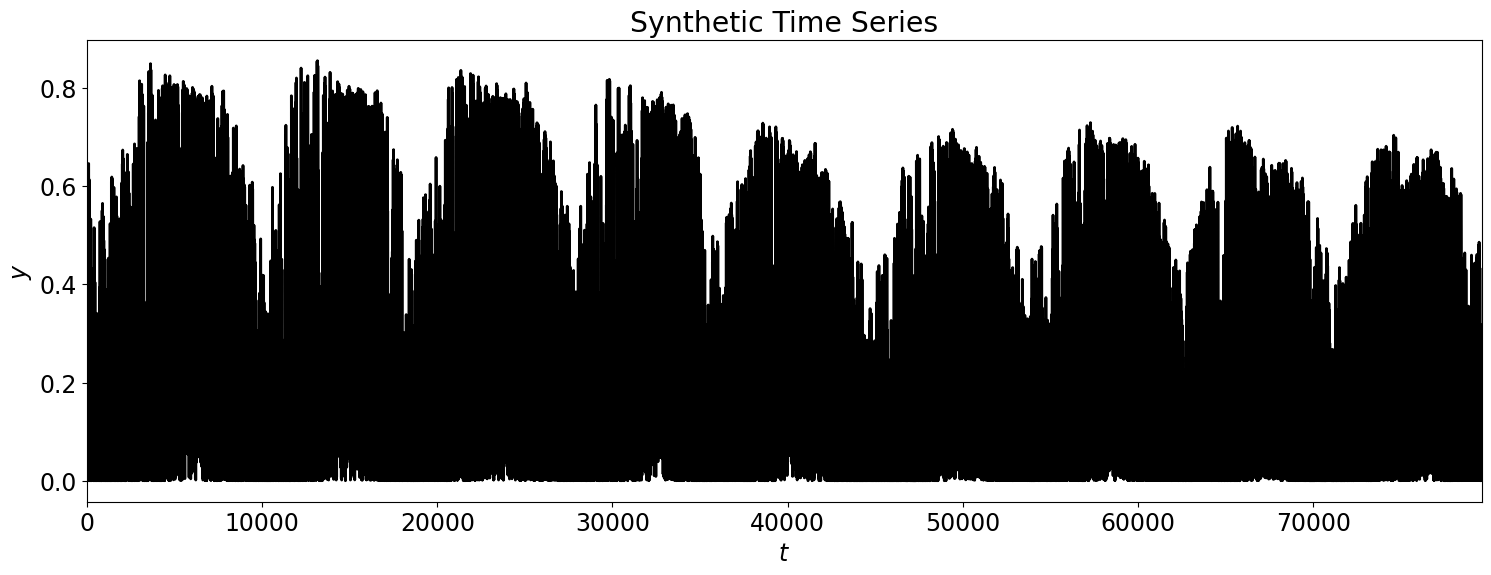

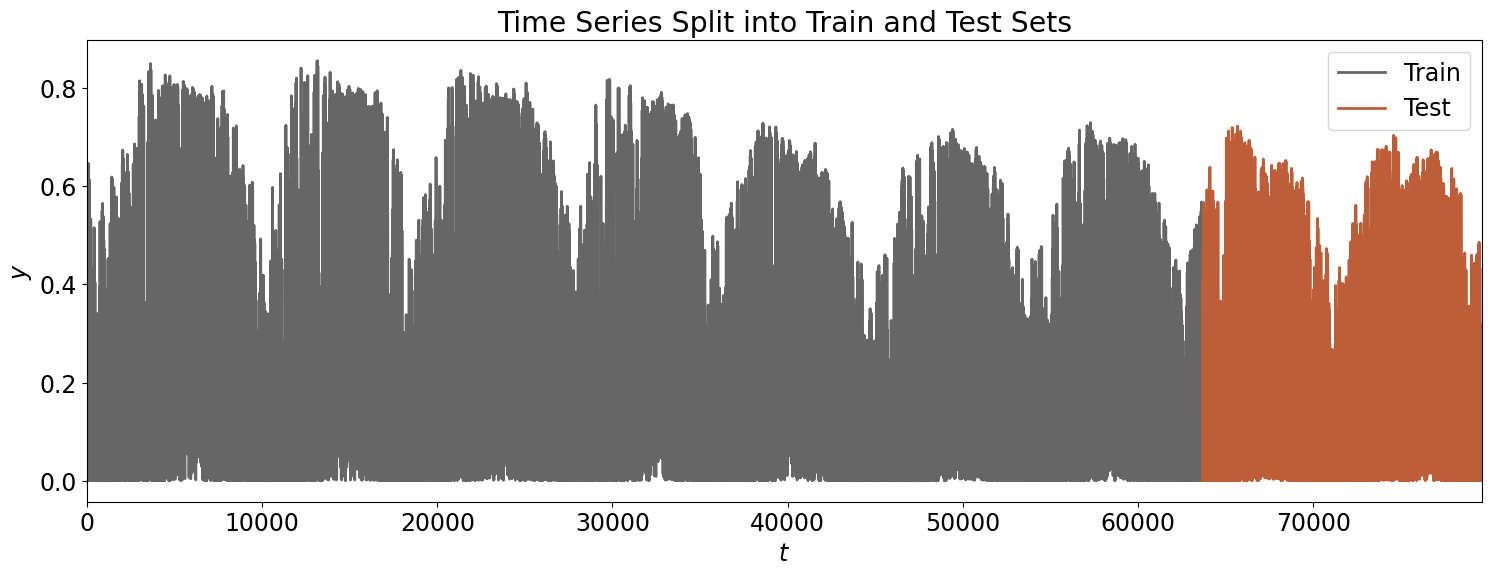

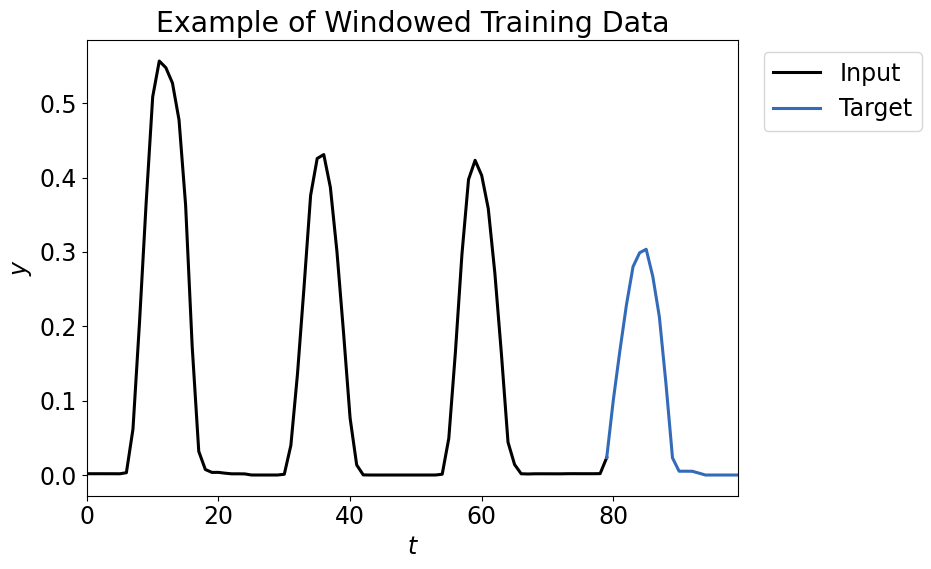

100%|██████████| 50/50 [1:30:29<00:00, 108.58s/it, loss=2.890]


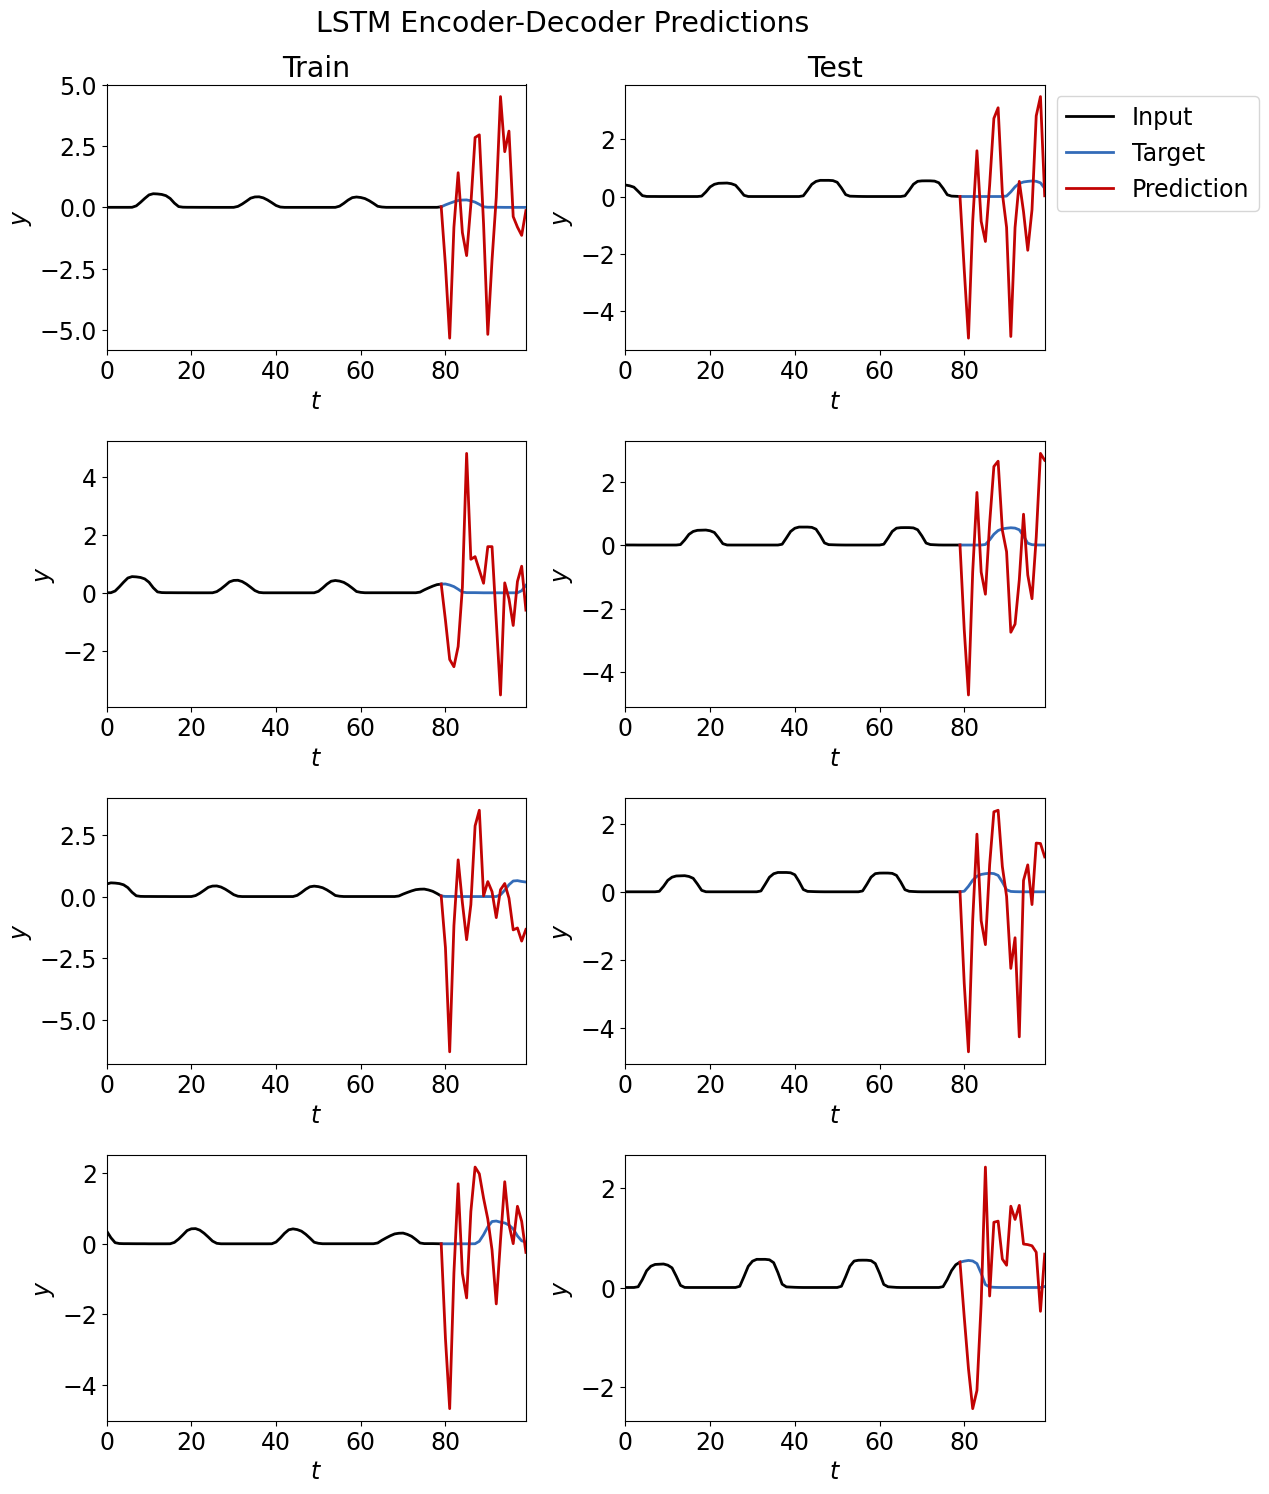

In [7]:
# Author: Laura Kulowski

'''

Example of using a LSTM encoder-decoder to model a synthetic time series 

'''

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
import sys

import generate_dataset
import lstm_encoder_decoder
import plotting 

matplotlib.rcParams.update({'font.size': 17})

#----------------------------------------------------------------------------------------------------------------
# generate dataset for LSTM
def read_dataset(name='../data/factor_capacidad_conjunto.csv',data='solar'):
    df = pd.read_csv(name,index_col=0,parse_dates=True)
    df.index.freq = 'H'
    return df[data]
y = read_dataset()
y = y.values
t = np.arange(len(y))
# t = np.arange(1000)
# y = np.sin(np.arange(1000) * 0.1) + np.random.randn(1000) * 0.1  # dummy sine wave data
# t, y = generate_dataset.synthetic_data()
t_train, y_train, t_test, y_test = generate_dataset.train_test_split(t, y, split = 0.8)

# plot time series 
plt.figure(figsize = (18, 6))
plt.plot(t, y, color = 'k', linewidth = 2)
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.title('Synthetic Time Series')
plt.show()

# plot time series with train/test split
plt.figure(figsize = (18, 6))
plt.plot(t_train, y_train, color = '0.4', linewidth = 2, label = 'Train') 
plt.plot(np.concatenate([[t_train[-1]], t_test]), np.concatenate([[y_train[-1]], y_test]),
         color = (0.74, 0.37, 0.22), linewidth = 2, label = 'Test')
plt.xlim([t[0], t[-1]])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Time Series Split into Train and Test Sets')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout
plt.show()

#----------------------------------------------------------------------------------------------------------------
# window dataset

# set size of input/output windows 
iw = 80 
ow = 20 
s = 5

# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(y_train, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(y_test, input_window = iw, output_window = ow, stride = s)

# plot example of windowed data  
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 
plt.show()

#----------------------------------------------------------------------------------------------------------------
# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

# specify model parameters and train
model = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 15)
loss = model.train_model(X_train, Y_train, n_epochs = 50, target_len = ow, batch_size = 5, training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)

# plot predictions on train/test data
plotting.plot_train_test_results(model, Xtrain, Ytrain, Xtest, Ytest)

plt.close('all')

